## LELEC2811 - E2 : Data Acquisition



In [254]:
#Import libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

### Exercise 1: Quantization and noise

The objectives of this exercise are (i) to derive the theoretical expression for the quantization noise floor, (ii) to discuss the hypotheses underlying this expression and (iii) to understand the impact of quantization on the power spectral density based on a practical study case.

1. From a mathematical point of view, the quantization noise, i.e. the difference between the actual and quantized signals, can be regarded as a random variable. Therefore, we ask you to compute the expected value and variance of the quantization noise. As a reminder,
![Figure1](figures\ex1_equation.png)
where $x$ denotes a random variable, $P(x)$ its probability density function, $\mathbb{E}(x)$ its expected value and $Var(x)$ its variance.

    Hint: What assumption is done regarding the shape of the probability density function $P(x)$?

    Short answer: $\mathbb{E}(x) = 0$ and $Var(x) = \frac{\Delta^2}{12}$ , where Delta stands for the least-significant bit (LSB).

2. Given that the quantization energy is the variance of the quantization noise, computed in the previous point, express the one-sided power spectral density of the quantization noise for a given sampling frequency $f_s$.

    Short answer: PSD = $\frac{\Delta^2}{6f_s}$

3. Compute the LSB and quantization noise PSD in dB/Hz for a number of bits $N$ = 2, 4, 8, assuming a full-scale voltage $V_{FS}$ = 1V and a sampling frequency $f_s$ = 100 kHz. A visualization is proposed below. In that code, the signal to be quantized is a sine wave at 100Hz with a peak-to-peak amplitude of $V_{FS}$.

In [255]:
N = 8 # Number of bits for quantization

In [256]:
# Parameters
vfs = 1       # Full-scale voltage in [V]
fsig = 100   # Signal frequency in [Hz]
fsamp = 1e5   # Sampling frequency in [Hz]

In [257]:
#********** Generate and quantize the signal **********#
# Measurement time
T = 2/fsig

# Signal creation (perfect sine + white noise)
np.random.seed(0)
t = np.linspace(start=1/fsamp, stop=T, num=(int(T*fsamp)))
rand_phase = (2*np.pi-0)*np.random.rand()
sig = (1/2) * vfs * (1 + np.sin(2*np.pi*fsig*t + rand_phase)) + (vfs/1e2)*np.random.rand(t.size)

# Quantization
quant_sig = np.round(sig*((2**N)-1))/((2**N)-1)
quant_error = sig-quant_sig
LSB = vfs/((2**N)-1)

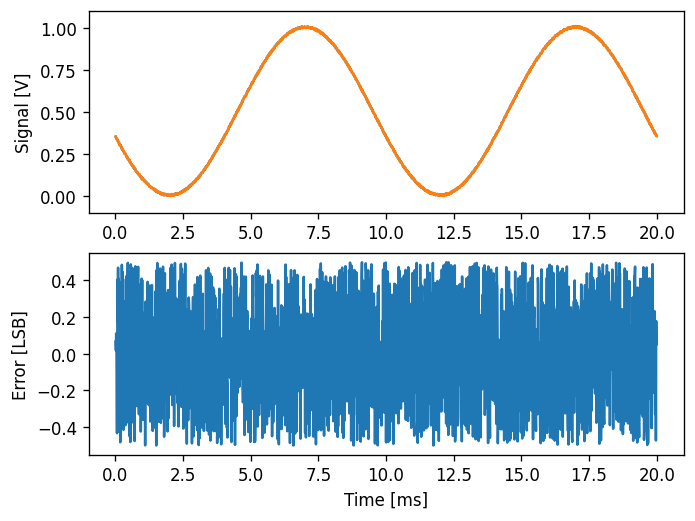

In [258]:
# Plot the signal (real and quantized)
fig = plt.figure(num = 1,dpi=120)
axs0 = fig.add_subplot(2,1,1)
axs1 = fig.add_subplot(2,1,2)

axs0.plot(1e3 * t, sig, 1e3 * t, quant_sig)
axs0.set_ylabel('Signal [V]')
axs0.set_ylim(-0.1, 1.1)

axs1.plot(1e3 * t, quant_error/LSB)
axs1.set_xlabel('Time [ms]')
axs1.set_ylabel('Error [LSB]')
plt.show()

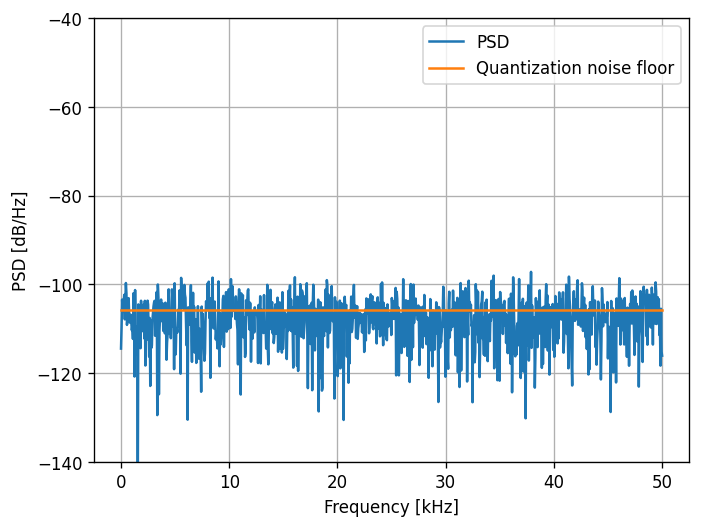

In [259]:
#********** Compute the power spectral density (PSD) **********#
# Number of samples
nsamples = sig.size

# Discrete Fourier Transform (DFT)
xdft = fft(quant_error)
xdft = xdft[0:(nsamples//2)]

# Power Spectral Density (PSD)
psdx = (1/(fsamp*nsamples)) * np.abs(xdft)**2
psdx[1:-2] = 2*psdx[1:-2]

# Quantization noise
quant_noise = (2/fsamp)*(LSB**2)/12

# Plot PSD
freq = np.linspace(start=0, stop=fsamp/2, num=nsamples//2)
fig = plt.figure(num = 2,dpi=120)
plt.plot(1e-3*freq, 10*np.log10(psdx), label='PSD')
plt.plot(1e-3*freq, 10*np.log10(quant_noise)*np.ones(nsamples//2), label='Quantization noise floor')
plt.legend(loc = "upper right")
plt.grid(True)
plt.xlabel('Frequency [kHz]')
plt.ylabel('PSD [dB/Hz]')
plt.ylim(-140, -40)
plt.show()

4. Discuss the validity of the assumption done on the shape of the probability density function $P(x)$, based on the histogram of the quantization error.

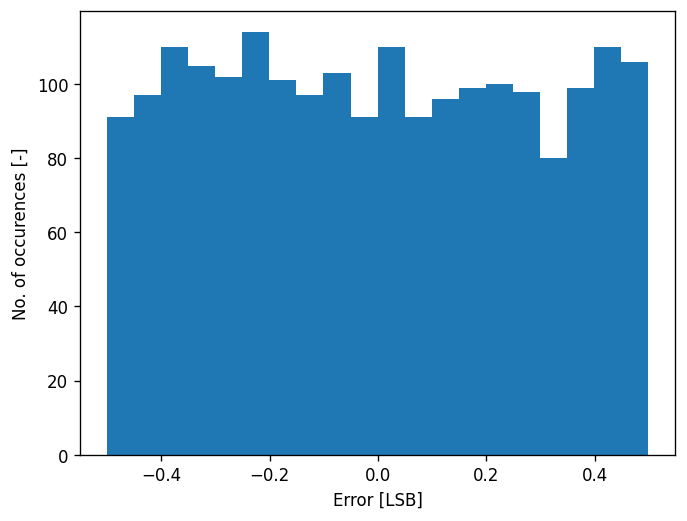

In [260]:
# Plot histogram of quantization error
fig = plt.figure(num = 3,dpi=120)
plt.hist(quant_error/LSB, bins=20)
plt.xlabel('Error [LSB]')
plt.ylabel('No. of occurences [-]')
plt.show()

### Exercise 2: Oversampling

The objectives of this exercise are (i) to understand the impact of oversampling on the quantization noise PSD, (ii) to study an oversampled data acquisition system and (iii) to discover conventional digital implementations for the anti-aliasing filter.

1. Compute the one-sided PSD of the quantization noise for
    * A data acquisition system using an ADC operating at Nyquist’s frequency, i.e. $f_s$ = $f_{s,ny}$.
    * A data acquisition system using an ADC operating above Nyquist’s frequency, i.e. $f_s$ = $OSR \times f{_s,ny}$, where
    $OSR$ denotes the oversampling factor.

    Both systems use an ideal anti-aliasing filter (AAF) with a cut-off frequency $f_c$ = $f_{s,ny}$

2. Let us now consider the oversampled data acquisition system presented in Fig. 1.
    * Describe the different operations performed by this system.
    * Draw the power spectral density at the output of the ADC and at the output of the sampling system.
![Figure3](figures\ex2_block_diagram.png)

3. The low-pass filter is usually implemented as a digital filter, more specifically a windowed-sinc finite-impulse
response (FIR) filter.
    * What is the advantage of implementing the low-pass filter (LPF) in the digital domain, using a FIR filter, instead of the analog domain?
    * Two types of windowing are commonly used for the sinc: the Hamming and the Blackman window. Compare them from the point of view of roll-off and stop band attenuation, using the Python code provided below.
![Figure2](figures\ex2_equation.png)

        where $M + 1$ denotes the number of points to which the sinc is truncated, $f_c$ the ratio between the filter cut-off frequency and the sampling frequency and $K$ a scaling factor such that all filter coeffcients sum to one. A good reference explaining windowed-sinc filter into more details is [[1](#references)].

In [261]:
import scipy.signal as spsig
np.random.seed(0)
# Filter parameters
fc = 0.1        # Cut-off frequency as a fraction of the sampling frequency
M = 50          # Number of points in the windowed sinc filter
ind = np.linspace(start=0, stop=M, num=M+1)

In [262]:
#********** Hamming filter **********#
# Define LPF weights
hamming = (np.sin(2*np.pi*fc*(ind-(M//2)))/(ind-(M//2)))
if (np.mod(M,2) == 0):
  hamming[M//2] = 2*np.pi*fc
hamming = hamming * (0.54 - 0.46*np.cos((2*np.pi*ind)/M))
hamming = hamming/sum(hamming)

C:\Users\vince\AppData\Local\Temp\ipykernel_4956\2382880164.py:3: RuntimeWarning: invalid value encountered in divide
  hamming = (np.sin(2*np.pi*fc*(ind-(M//2)))/(ind-(M//2)))


In [263]:
#********** Blackman filter **********#
# Define LPF weights
blackman = (np.sin(2*np.pi*fc*(ind-(M//2)))/(ind-(M//2)))
if (np.mod(M,2) == 0):
  blackman[M//2] = 2*np.pi*fc
blackman = blackman * (0.42 - 0.5*np.cos((2*np.pi*ind)/M) + 0.08*np.cos((4*np.pi*ind)/M))
blackman = blackman/sum(blackman)

C:\Users\vince\AppData\Local\Temp\ipykernel_4956\2512256554.py:3: RuntimeWarning: invalid value encountered in divide
  blackman = (np.sin(2*np.pi*fc*(ind-(M//2)))/(ind-(M//2)))


<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
C:\Users\vince\AppData\Local\Temp\ipykernel_4956\1979543681.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$20\log_{10}|H(z)|$ [dB]')


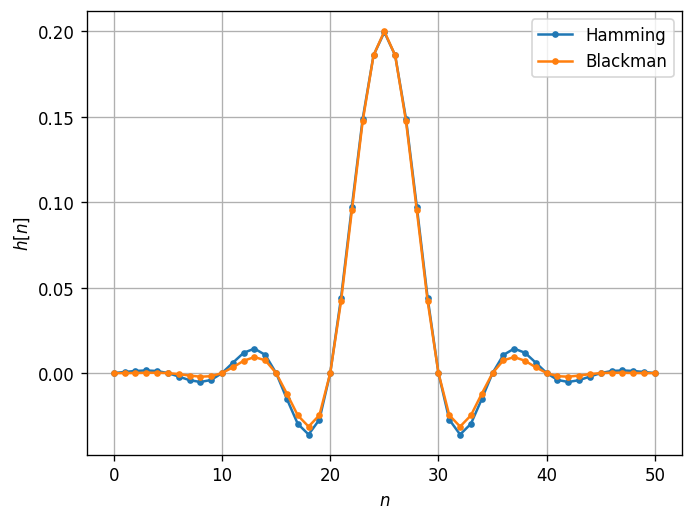

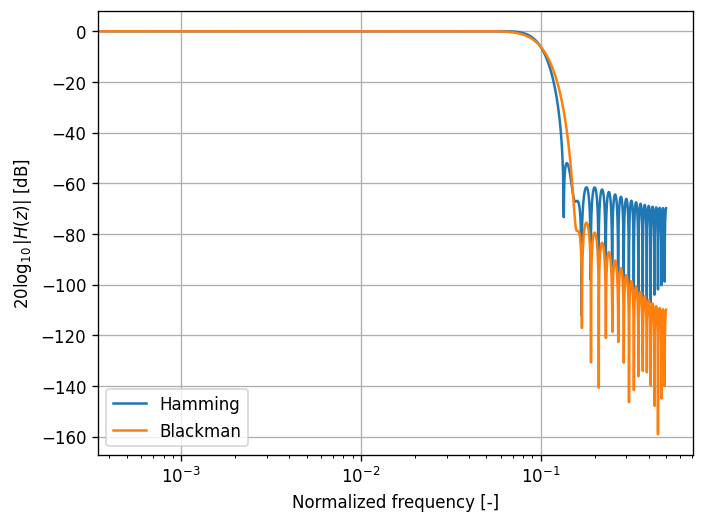

In [264]:
#********** Plot **********#
# Plot LPF coefficients
fig = plt.figure(num = 4,dpi=120)
plt.plot(ind, hamming, marker='.', label='Hamming')
plt.plot(ind, blackman, marker='.', label='Blackman')
plt.legend(loc = "upper right")
plt.grid(True)
plt.xlabel('$n$')
plt.ylabel('$h[n]$')

# Frequency response of the LPF
ndata = 1024
w1, h1 = spsig.freqz(b=hamming, a=1, worN=ndata)
w2, h2 = spsig.freqz(b=blackman, a=1, worN=ndata)

fig = plt.figure(num = 5,dpi=120)
plt.plot(w1/(2*np.pi), 20*np.log10(np.abs(h1)), label='Hamming')
plt.plot(w2/(2*np.pi), 20*np.log10(np.abs(h2)), label='Blackman')
plt.legend(loc = "lower left")
plt.grid(True)
plt.xlabel('Normalized frequency [-]')
plt.xscale('log')
plt.ylabel('$20\log_{10}|H(z)|$ [dB]')
plt.show()

4. Discuss qualitatively the results obtained for $N$ = 2, 4, 8 bits, for an oversampling factor of 64, based on the Python code provided below.
    * Does the theoretical quantization noise floor match the actual one?
    * How do you explain the peaks in the power spectral density of the quantization error?

#### Parameters :

In [283]:
N = 8          # Number of bits for quantization
OSR = 64          # Oversampling ratio

In [284]:
np.random.seed(25)
# Parameters
vdd = 1           # Full-scale voltage in [V]
fsig = 125        # Signal frequency in [Hz]
fsamp = 1e4       # Sampling frequency in [Hz]
fosr = OSR*fsamp  # Oversampling frequency

#### Raw signal generation :

In [285]:
# Measurement time
T = 5/fsig

# Time vectors
t_samp = np.linspace(start=1/fsamp, stop=T, num=int(T*fsamp))
t_osr = np.linspace(start=1/fosr, stop=T, num=int(T*fosr))

# Raw signal creation (sum of sines + white noise)
rand_phase_1 = 2*np.pi*np.random.rand()
rand_phase_2 = 2*np.pi*np.random.rand()
sig_samp = vdd/2 + vdd/6 * (np.sin(2*np.pi*fsig*t_samp) + np.sin(2*np.pi*3*fsig*t_samp + rand_phase_1) + np.sin(2*np.pi*7*fsig*t_samp + rand_phase_2)) + (vdd/1e3)*np.random.rand(t_samp.size)
sig_osr  = vdd/2 + vdd/6 * (np.sin(2*np.pi*fsig*t_osr)  + np.sin(2*np.pi*3*fsig*t_osr  + rand_phase_1) + np.sin(2*np.pi*7*fsig*t_osr  + rand_phase_2)) + (vdd/1e3)*np.random.rand(t_osr.size)


#### Quantization and resulting PSD w/o OSR

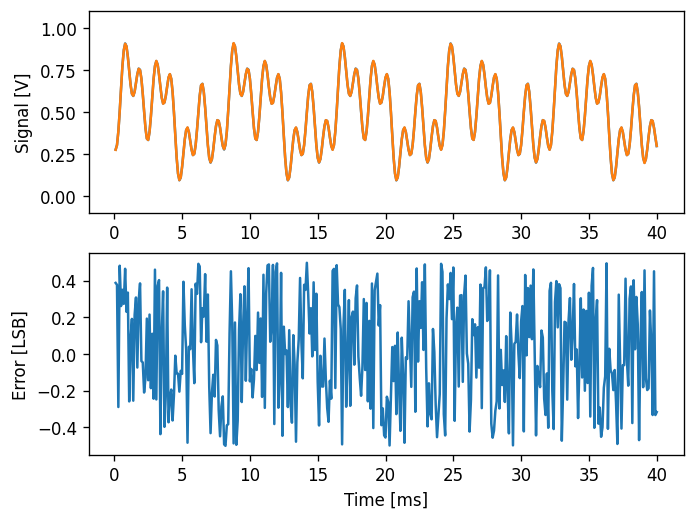

In [286]:
# Quantization
quant_sig_samp = np.round(sig_samp*((2**N)-1))/((2**N)-1)
quant_error_samp = sig_samp - quant_sig_samp
LSB = vdd/(2**N)

# Plot signal and quantized signal vs. time
fig = plt.figure(num = 6,dpi=120)
axs0 = fig.add_subplot(2,1,1)
axs1 = fig.add_subplot(2,1,2)

axs0.plot(1e3 * t_samp, sig_samp, 1e3 * t_samp, quant_sig_samp)
axs0.set_ylabel('Signal [V]')
axs0.set_ylim(-0.1, 1.1)

# Plot quantization error vs. time
axs1.plot(1e3 * t_samp, quant_error_samp/LSB)
axs1.set_xlabel('Time [ms]')
axs1.set_ylabel('Error [LSB]')
axs1.set_ylim(-0.55, 0.55)
plt.show()

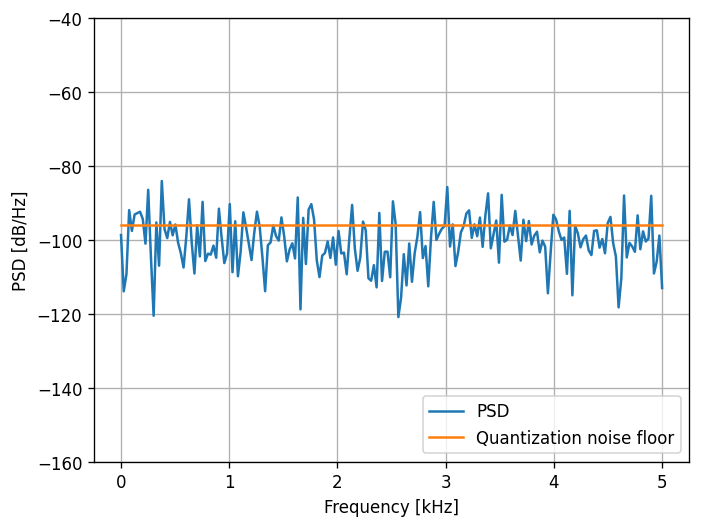

In [287]:
#********** PSD w/o OSR **********#
# Number of samples
nsamples = sig_samp.size

# Discrete Fourier Transform (DFT)
xdft = fft(quant_error_samp)
xdft = xdft[0:(nsamples//2)]

# PSD
psdx = (1/(fsamp*nsamples)) * np.abs(xdft)**2
psdx[1:-2] = 2*psdx[1:-2]

# Quantization noise
quant_noise = (2/fsamp)*(LSB**2)/12

# Plot PSD
freq = np.linspace(start=0, stop=fsamp/2, num=nsamples//2)
fig = plt.figure(num = 7,dpi=120)
plt.plot(1e-3*freq, 10*np.log10(psdx), label='PSD')
plt.plot(1e-3*freq, 10*np.log10(quant_noise)*np.ones(nsamples//2), label='Quantization noise floor')
plt.legend(loc = "lower right")
plt.grid(True)
plt.xlabel('Frequency [kHz]')
plt.ylabel('PSD [dB/Hz]')
plt.ylim(-160, -40)
plt.show()

#### Digital low-pass filtering, quantization and resulting PSD w/ OSR

In [288]:
#********** Digital low-pass filtering **********#
# Parameters
fc = 0.5/OSR    # Cut-off frequency as a function of the sampling frequency
M = 255         # Number of points in the windowed sinc

# Define Blackman LPF weights
ind = np.linspace(start=0, stop=M, num=M+1)
lpf = (np.sin(2*np.pi*fc*(ind-(M/2)))/(ind-(M/2)))
if (np.mod(M,2) == 0):
  lpf[(M//2)] = 2*np.pi*fc
lpf = lpf * (0.42 - 0.5*np.cos((2*np.pi*ind)/M) + 0.08*np.cos((4*np.pi*ind)/M))
lpf = lpf/np.sum(lpf)

# Quantization
quant_sig_osr = np.round(sig_osr*((2**N)-1))/((2**N)-1)

# Zero-padding
sig_padded = np.concatenate((np.zeros((M+1)//2), sig_osr, np.zeros((M+1)//2)))
quant_sig_padded = np.concatenate((np.zeros((M+1)//2), quant_sig_osr, np.zeros((M+1)//2)))

# Digital filtering
nsamples_osr = sig_osr.size
sig_lpf = np.zeros(nsamples_osr)
quant_sig_lpf = np.zeros(nsamples_osr)
for i in range(0, nsamples_osr-1):
  sig_lpf[i] = np.dot(sig_padded[i:i+M+1], lpf)
  quant_sig_lpf[i] = np.dot(quant_sig_padded[i:i+M+1], lpf)


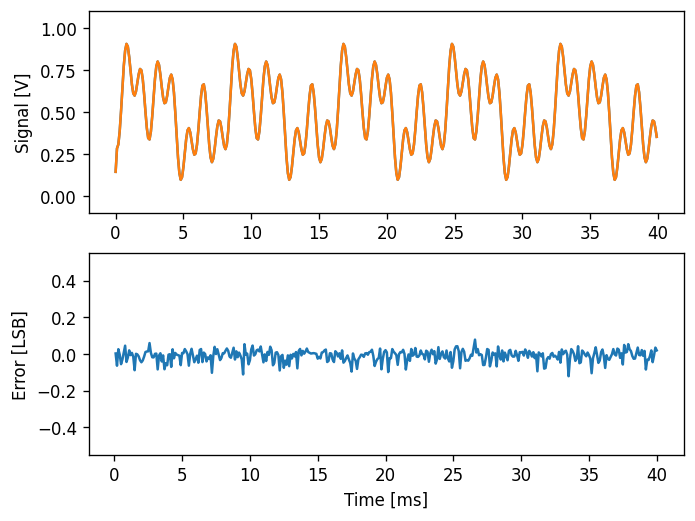

In [280]:
#********** Downsampling by OSR factor **********#
nsamples_down = np.floor(quant_sig_lpf.size//OSR).astype(dtype=int)
t_down = np.zeros(nsamples_down)
sig_lpf_down = np.zeros(nsamples_down)
quant_sig_lpf_down = np.zeros(nsamples_down)

for i in range(0, nsamples_down):
  t_down[i] = t_osr[OSR*i]
  sig_lpf_down[i] = sig_lpf[OSR*i]
  quant_sig_lpf_down[i] = quant_sig_lpf[OSR*i]

# Compute quantization error
quant_error = sig_lpf_down - quant_sig_lpf_down

# Plot signal and quantized signal vs. time
fig = plt.figure(num = 7,dpi=120)
axs0 = fig.add_subplot(2,1,1)
axs1 = fig.add_subplot(2,1,2)

axs0.plot(1e3 * t_down, sig_lpf_down, 1e3 * t_down, quant_sig_lpf_down)
axs0.set_ylabel('Signal [V]')
axs0.set_ylim(-0.1, 1.1)

# Plot quantization error vs. time
axs1.plot(1e3 * t_samp, quant_error/LSB)
axs1.set_xlabel('Time [ms]')
axs1.set_ylabel('Error [LSB]')
axs1.set_ylim(-0.55, 0.55)
plt.show()

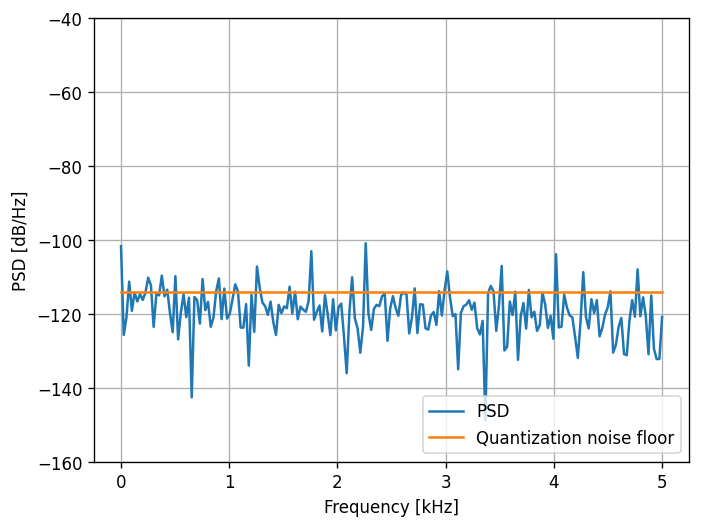

In [281]:
#********** Compute PSD w/ OSR **********#
# Discrete Fourier Transform (DFT)
xdft = fft(quant_error)
xdft = xdft[0:nsamples_down//2]

# Power Spectral Density (PSD)
psdx_down = (1/(fsamp*nsamples_down)) * np.abs(xdft)**2
psdx_down[1:-2] = 2*psdx_down[1:-2]

# Quantization noise
quant_noise_down = (1/OSR)*quant_noise

# Plot PSD
freq_down = np.linspace(start=0, stop=fsamp/2, num=nsamples_down//2)
fig = plt.figure(num = 8,dpi=120)
plt.plot(1e-3*freq_down, 10*np.log10(psdx_down), label='PSD')
plt.plot(1e-3*freq_down, 10*np.log10(quant_noise_down)*np.ones(nsamples_down//2), label='Quantization noise floor')
plt.legend(loc = "lower right")
plt.grid(True)
plt.xlabel('Frequency [kHz]')
plt.ylabel('PSD [dB/Hz]')
plt.ylim(-160, -40)
plt.show()

#### Comparison of the PSD with and without oversampling

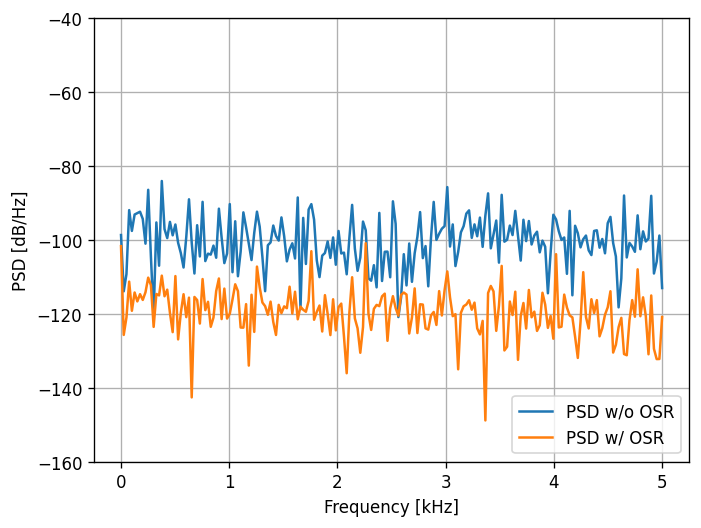

In [282]:
#********** Plot PSD w/o and w/ OSR **********#
fig = plt.figure(num = 9,dpi=120)
plt.plot(1e-3*freq, 10*np.log10(psdx), label='PSD w/o OSR')
plt.plot(1e-3*freq_down, 10*np.log10(psdx_down), label='PSD w/ OSR')
plt.legend(loc = "lower right")
plt.grid(True)
plt.xlabel('Frequency [kHz]')
plt.ylabel('PSD [dB/Hz]')
plt.ylim(-160, -40)
plt.show()

# References
<a id='references'></a>

[1] S. W. Smith, "The Scientist and Engineer’s Guide to Digital Signal Processing", California Technical Publishing, 1998